# [AIM 2022](https://data.vision.ee.ethz.ch/cvl/aim22/) - Reverse ISP Challenge

### [Track 1 - S7](https://codalab.lisn.upsaclay.fr/competitions/5079)
### [Track 2 - HP20](https://codalab.lisn.upsaclay.fr/competitions/5080)


<img src=https://i.ibb.co/wgRBGQq/aim-challenge-teaser.jpg>


Digital cameras transform sensor RAW readings into RGB images by means of their Image Signal Processor (ISP). Computational photography tasks such as image denoising and colour constancy are commonly performed in the RAW domain, in part due to the inherent hardware design, but also due to the appealing simplicity of noise statistics that result from the direct sensor readings. Despite this, the availability of RAW images is limited in comparison with the abundance and diversity of available RGB data. Recent approaches have attempted to bridge this gap by estimating the RGB to RAW mapping.

In this challenge, we look for solutions to recover RAW readings from the camera using only the corresponding RGB images processed by the in-camera ISP. Successful solutions should generate plausible RAW images, and by doing this, other downstream tasks like Denoising, Super-resolution or Colour Constancy can benefit from such synthetic data generation.

## Datasets

**Samsung S7**

We use a custom version of the dataset collected by Schwartz et al. in their work *[DeepISP: Learning End-to-End Image Processing Pipeline](https://arxiv.org/abs/1801.06724)*. We process the original RAW images (GRBG pattern) and extract "aligned" RGB-RAW crop pairs.

**EH Huawei P20 Dataset**

We use a custom version of the dataset from [ETH PyNET by Ignatov et al.](http://people.ee.ethz.ch/~ihnatova/pynet.html#dataset), a large-scale dataset consisting of RAW-RGB image pairs captured in the wild with the Huawei P20 camera (12.3 MP Sony Exmor IMX380 sensor).
More information in their paper *[Replacing Mobile Camera ISP with a Single Deep Learning Model](https://arxiv.org/abs/2002.05509)*


In both tracks, we provide RAW and RGB images extracted from the camera ISP. 
- RAW images are provided in `.npy` format, as 4-channel images following the RGGB pattern
- RGB images are provided in `.jpg` format

You can download the competition data after registering at the challenge [here](https://codalab.lisn.upsaclay.fr/competitions/5079).

- Track 1 data is approx 3 Gb
- Track 2 data is approx 2.5 Gb

## Hints and Tips

- RAW images are provided as `np.uint16` with max value `2**10 = 1024`. 
- The RAW images are packed as (h,w,4) , you can unpack it and obtain a (h*2, w*2,1) RAW using the corresponding utils. We recommend to use the 4-channel RAW image.
- RAW images are already converted to standard RGGB pattern.
- Mosaic and Demosaic are provided for visualization purposes only.
- For the S7 dataset, most of the images are well-aligned, SSIM and PSNR should work as perceptual metrics.
- For the HP20 dataset, most of the images are **not** aligned. The RGB from the ISP is the process of many transformations includding cropping and zooming. Therefore we recomend perceptual losses as SSIM, MSSSIM and KL-Divergence. In this track, we focus on SSIM as standard metric, but we will consider internally the other mentioned metrics. 
- The ISP corrects many artifacts such as noise and blur. The original RAW images threfore might contain such artifacts.

In [1]:
!pip -q install gdown
!pip -q install rawpy

At the challenge website you can register and access to the data: https://codalab.lisn.upsaclay.fr/competitions/5079

The data sctructure should be as follows:

```
├── data-p20
│   ├── train
│   └── val_rgb
└── data-s7
    ├── train
    └── val_rgb
    
```

`data-p20` should be around 3 Gb and `data-s7` should be around 2.5 Gb

- `train/` contains RGBs in `.jpg` format and RAWs in `.npy` format
- `val_rgb/` contains RGBs in `.jpg`

From the corresponding RGBs, you need to reverse the ISP operations an provide the corresponding RAW image.

In [7]:
!du -sh data-p20 data-s7

3.2G	data-p20
2.5G	data-s7


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imageio
import rawpy
import sys
import os
import gc
import time
import random
from glob import glob
from tqdm import tqdm
from collections import defaultdict
from IPython import display
from skimage.metrics import mean_squared_error as MSE
from skimage.metrics import structural_similarity as SSIM

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from torch.optim import Adam

torch.backends.cudnn.deterministic = True
device = torch.device("cuda")

print("CUDA visible devices: " + str(torch.cuda.device_count()))

CUDA visible devices: 1


### Utils

In [9]:
# Check https://github.com/mv-lab/AISP/utils.py for more utils for RAW image manipulation.

def load_img (filename, debug=False, norm=True, resize=None):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if norm:   
        img = img / 255.
        img = img.astype(np.float32)
    if debug:
        print (img.shape, img.dtype, img.min(), img.max())
        
    if resize:
        img = cv2.resize(img, (resize[0], resize[1]), interpolation = cv2.INTER_AREA)
        
    return img

def save_rgb (img, filename):
    if np.max(img) <= 1:
        img = img * 255
    
    img = img.astype(np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
    cv2.imwrite(filename, img)
    

def load_raw(raw, max_val=2**10):
    raw = np.load (raw)/ max_val
    return raw.astype(np.float32)


########## VISUALIZATION

def demosaic (raw):
    """Simple demosaicing to visualize RAW images
    Inputs:
     - raw: (h,w,4) RAW RGGB image normalized [0..1] as float32
    Returns: 
     - Simple Avg. Green Demosaiced RAW image with shape (h*2, w*2, 3)
    """
    
    assert raw.shape[-1] == 4
    shape = raw.shape
    
    red        = raw[:,:,0]
    green_red  = raw[:,:,1]
    green_blue = raw[:,:,2]
    blue       = raw[:,:,3]
    avg_green  = (green_red + green_blue) / 2
    image      = np.stack((red, avg_green, blue), axis=-1)
    image      = cv2.resize(image, (shape[1]*2, shape[0]*2))
    return image


def mosaic(rgb):
    """Extracts RGGB Bayer planes from an RGB image."""
    
    assert rgb.shape[-1] == 3
    shape = rgb.shape
    
    red        = rgb[0::2, 0::2, 0]
    green_red  = rgb[0::2, 1::2, 1]
    green_blue = rgb[1::2, 0::2, 1]
    blue       = rgb[1::2, 1::2, 2]
    
    image = np.stack((red, green_red, green_blue, blue), axis=-1)
    return image


def gamma_compression(image):
    """Converts from linear to gamma space."""
    return np.maximum(image, 1e-8) ** (1.0 / 2.2)

def tonemap(image):
    """Simple S-curved global tonemap"""
    return (3*(image**2)) - (2*(image**3))

def postprocess_raw(raw):
    """Simple post-processing to visualize demosaic RAW imgaes
    Input:  (h,w,3) RAW image normalized
    Output: (h,w,3) post-processed RAW image
    """
    raw = gamma_compression(raw)
    raw = tonemap(raw)
    raw = np.clip(raw, 0, 1)
    return raw

def plot_pair (rgb, raw, t1='RGB', t2='RAW', axis='off'):
    
    fig = plt.figure(figsize=(12, 6), dpi=80)
    plt.subplot(1,2,1)
    plt.title(t1)
    plt.axis(axis)
    plt.imshow(rgb)

    plt.subplot(1,2,2)
    plt.title(t2)
    plt.axis(axis)
    plt.imshow(raw)
    plt.show()

########## METRICS

def PSNR(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    if(mse == 0):  
        return np.inf
    
    max_pixel = np.max(y_true)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [10]:
def get_filenames(path):
    train_raws = sorted(glob(PATH + '/train/*.npy'))
    train_rgbs = sorted(glob(PATH + '/train/*.jpg'))
    valid_rgbs = sorted(glob(PATH + '/val_rgb/*'))
    assert len(train_raws) == len(train_rgbs)
    print (f'Training samples: {len(train_raws)} \t Validation samples: {len(valid_rgbs)}')
    return train_raws, train_rgbs, valid_rgbs

In [11]:
DATASET = 's7'
PATH    = f'data-{DATASET}'

BATCH_TRAIN = 8
BATCH_TEST  = 1

# if DEBUG use only 250 datasamples, if not all the dataset
DEBUG = True 

train_raws, train_rgbs, valid_rgbs = get_filenames(PATH)

Training samples: 4320 	 Validation samples: 480


## Dataloader

In [12]:
class LoadData(Dataset):

    def __init__(self, root, rgb_files, raw_files=None, debug=False, test=None):
        
        self.root = root
        self.test = test
        self.rgbs = sorted(rgb_files)
        if self.test:
            self.raws = None
        else:
            self.raws = sorted(raw_files)
            
        self.debug = debug
        if self.debug:
            self.rgbs = self.rgbs[:100]
            self.raws = self.raws[:100]
        
    def __len__(self):
        return len(self.rgbs)

    def __getitem__(self, idx):

        rgb = load_img (self.rgbs[idx], norm=True)
        rgb = torch.from_numpy(rgb.transpose((2, 0, 1)))
        
        if self.test:
            return rgb, self.rgbs[idx]
        else:
            raw = load_raw (self.raws[idx])
            raw = torch.from_numpy(raw.transpose((2, 0, 1)))
            return rgb, raw

In [13]:
train_dataset = LoadData(root=PATH, rgb_files=train_rgbs,raw_files=train_raws, debug=DEBUG, test=False)
train_loader  = DataLoader(dataset=train_dataset, batch_size=BATCH_TRAIN, shuffle=True, num_workers=1,
                          pin_memory=True, drop_last=True)

test_dataset = LoadData(root=PATH, rgb_files=valid_rgbs, test=True)
test_loader  = DataLoader(dataset=test_dataset, batch_size=BATCH_TEST, shuffle=False, num_workers=1,
                         pin_memory=True, drop_last=False)

print (f'Train Dataloader BS={BATCH_TRAIN} N={len(train_loader)} / Test/Val Dataloader BS={BATCH_TEST} N={len(test_loader)}')

Train Dataloader BS=8 N=12 / Test/Val Dataloader BS=1 N=480


In [14]:
## Sanity Check - OK

#train_loader = iter(train_loader)
#batch = train_loader.next()
#batch[0].shape, batch[1].shape

#for _rgb, _raw in zip(batch[0], batch[1]):
#    _rgb = _rgb.permute(1, 2, 0).numpy()
#    _raw = _raw.permute(1, 2, 0).numpy()
#    print (_rgb.shape, _raw.shape)
#    plot_pair(_rgb, postprocess_raw(demosaic(_raw)), t1=f'RGB', t2='RAW Demosaic')
#    break

## Baseline UNet model

In [15]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x

class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs

class Decoder(nn.Module):
    def __init__(self, chs=(256, 128, 64)):
        super().__init__()
        self.chs        = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = encoder_features[i]
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x


class UNet(nn.Module):
    '''
    Simple UNet-like model 
    Input: RGB image. For S7 (504, 504, 3), and for P20 (496, 496, 3) 
    
    Outputs: RAW image as 4-channels (H // 2, W // 2, 4) following RGGB pattern.
             For the S7 output should be (252, 252, 4), and for HP20  (248, 248, 4)
    '''
    def __init__(self, enc_chs=(3,64,128,256), dec_chs=(256, 128, 64), out_ch=4, out_sz=(252, 252)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], out_ch, 1)
        self.out_sz      = out_sz

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out = self.head(out)
        out = F.interpolate(out, self.out_sz)
        out = torch.clamp(out, min=0., max=1.)
        return out

## Training

In [29]:
class CFG:
    
    encoder = (3,64,128,256)
    decoder = (256, 128, 64)
    out_ch  = 4
    out_sz  = (252, 252) #(248, 248)
    lr      = 1e-3
    lr_decay= 1e-6
    epochs  = 20
    loss    = nn.MSELoss()
    name    = 'unet-rev-isp.pt'
    out_dir = './'
    save_freq = 5

In [30]:
model = UNet(enc_chs=CFG.encoder, dec_chs=CFG.decoder, out_ch=CFG.out_ch, out_sz=CFG.out_sz)
model = model.to(device)
opt   = torch.optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.lr_decay)

criterion = CFG.loss
metrics   = defaultdict(list)

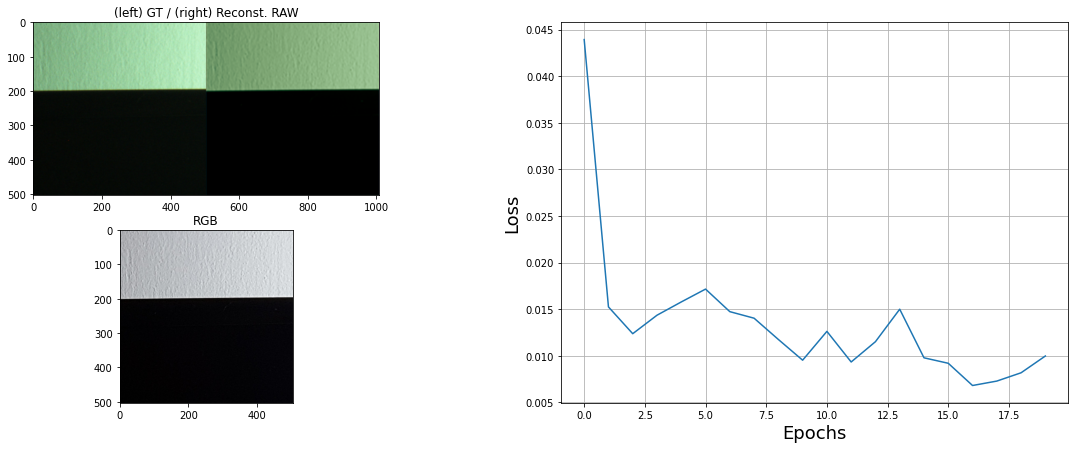

Epoch 20 of 20 took 12.838s



In [31]:
for epoch in range(CFG.epochs):
    
    torch.cuda.empty_cache()
    start_time = time.time()
    train_loss = []

    model.train()
    
    for rgb_batch, raw_batch in tqdm(train_loader):
        opt.zero_grad()

        rgb_batch = rgb_batch.to(device)
        raw_batch = raw_batch.to(device)
        
        recon_raw = model(rgb_batch)

        loss = criterion(raw_batch, recon_raw)
        loss.backward()
        opt.step()

        train_loss.append(loss.item())

    metrics['train_loss'].append(np.mean(train_loss))

    display.clear_output()
    plt.figure(figsize=(20, 7))
    ax1 = plt.subplot(2, 2, 1)
    reconst_raw = postprocess_raw(demosaic(recon_raw[-1].detach().cpu().permute(1, 2, 0).numpy()))
    gt_raw = postprocess_raw(demosaic(raw_batch[-1].detach().cpu().permute(1, 2, 0).numpy()))
    cmp_raw_gt = np.concatenate([gt_raw, reconst_raw], axis=1)
    ax1.imshow(cmp_raw_gt)
    ax1.set_title('(left) GT / (right) Reconst. RAW')

    ax2 = plt.subplot(2, 2, 3)
    ax2.imshow(rgb_batch[-1].detach().cpu().permute(1, 2, 0).numpy())
    ax2.set_title('RGB')

    ax3 = plt.subplot(1, 2, 2)
    ax3.plot(metrics['train_loss'], label='train')
    ax3.set_xlabel('Epochs', fontsize=18)
    ax3.set_ylabel('Loss', fontsize=18)
    ax3.grid()

    plt.show()
    
    print(f"Epoch {epoch + 1} of {CFG.epochs} took {time.time() - start_time:.3f}s\n")

    if ((epoch + 1) % CFG.save_freq == 0):
        torch.save(model, os.path.join(CFG.out_dir , f'{epoch+1}.pt'))
        

torch.save(model.state_dict(), os.path.join(CFG.out_dir ,CFG.name))

## Submission

In [32]:
!mkdir submission

  0%|          | 0/480 [00:00<?, ?it/s]

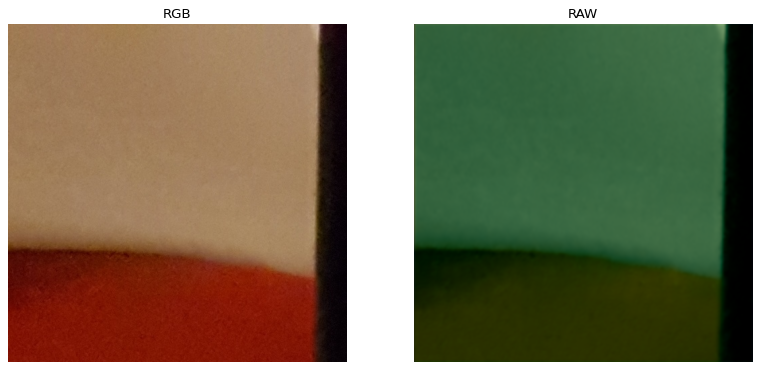

 21%|██        | 99/480 [00:06<00:20, 18.25it/s]

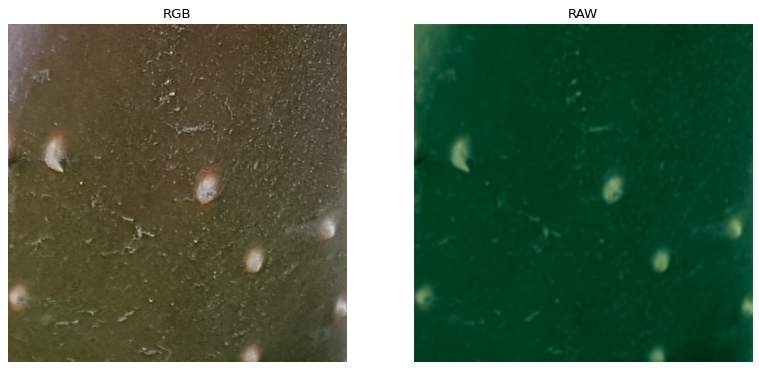

 41%|████▏     | 199/480 [00:11<00:16, 17.48it/s]

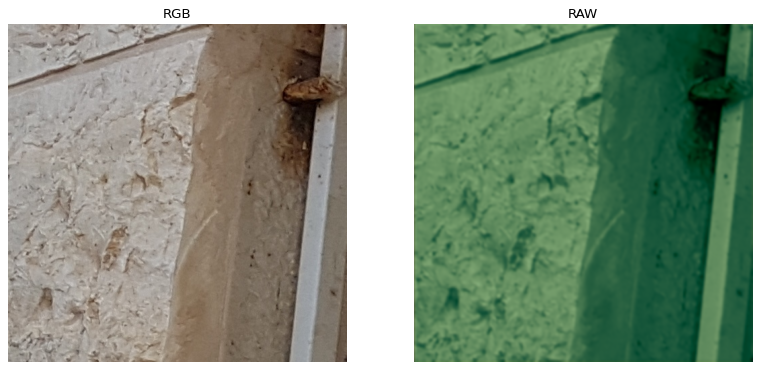

 62%|██████▏   | 299/480 [00:17<00:10, 18.10it/s]

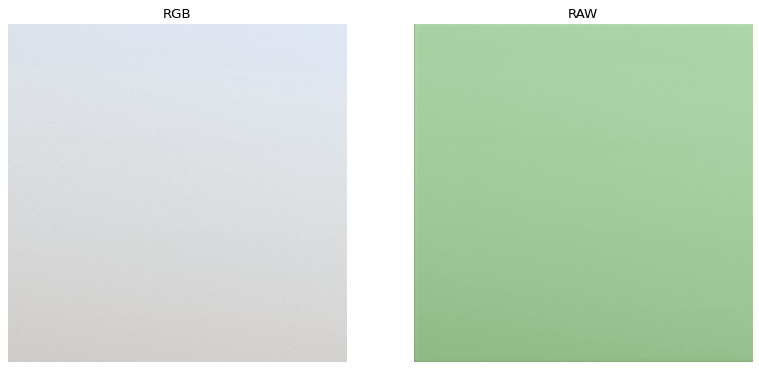

 83%|████████▎ | 399/480 [00:23<00:04, 18.30it/s]

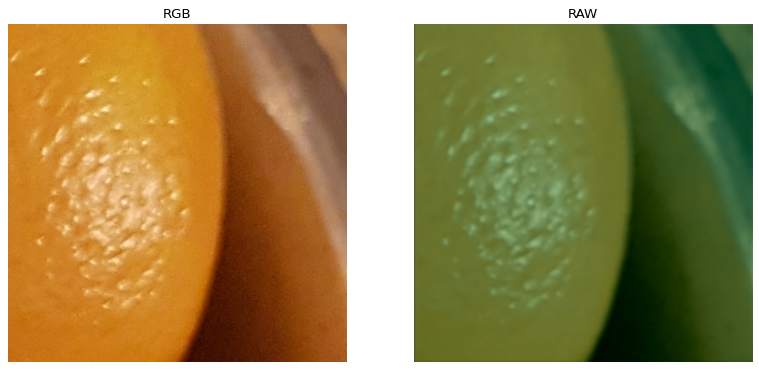

100%|██████████| 480/480 [00:28<00:00, 16.74it/s]

0.003631361822287242


In [33]:
SUBMISSION_PATH = './submission/'
runtime = []

cnt = 0
model.eval()
with torch.no_grad():
    for (rgb_batch, rgb_name) in tqdm(test_loader):
        rgb_batch = rgb_batch.to(device)
        rgb_name  = rgb_name[0].split('/')[-1].replace('.jpg', '')
        
        st = time.time()
        recon_raw = model(rgb_batch)
        tt = time.time() - st
        runtime.append(tt)
        
        recon_raw = recon_raw[0].detach().cpu().permute(1, 2, 0).numpy()
        rgb_batch = rgb_batch[0].detach().cpu().permute(1, 2, 0).numpy()
        
        if cnt % 100 == 0:
            plot_pair(rgb_batch, postprocess_raw(demosaic(recon_raw)))
        
        ## save as np.uint16
        assert recon_raw.shape[-1] == 4
        recon_raw = (recon_raw * 1024).astype(np.uint16)
        np.save(SUBMISSION_PATH + rgb_name + '.npy', recon_raw) 
        cnt+=1

print (np.mean(runtime)) ## add into the readme!

In [34]:
%%writefile submission/readme.txt

runtime per frame [s] : 0.0036
CPU[1] / GPU[0] : 1
Extra Data [1] / No Extra Data [0] : 0
Other description : Baseline UNet submission https://github.com/mv-lab/AISP

Writing submission/readme.txt


In [35]:
!ls submission | head

10_0.npy
10_1.npy
10_10.npy
10_11.npy
10_12.npy
10_13.npy
10_14.npy
10_15.npy
10_16.npy
10_17.npy


In [36]:
!zip -rq submission.zip submission/

In [37]:
!du -sh submission/ submission.zip

235M	submission/
80M	submission.zip


## Done! Thanks for participating

Go to the challenge website:

**[Track 1 - S7](https://codalab.lisn.upsaclay.fr/competitions/5079)**

**[Track 2 - HP20](https://codalab.lisn.upsaclay.fr/competitions/5080)**

Click on `Participate` and upload your submission, in some seconds you should see the score. Refresh the page if the submission `status` does not change.

<a href="https://codalab.lisn.upsaclay.fr/competitions/5079"><img src="https://i.ibb.co/8BBZxSF/Screenshot-from-2022-06-11-22-05-17.png" alt="" border="0"></a>